In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

In [1]:
host = r'127.0.0.1'
db = r'MSDS610' 
user = r'postgres'
pw = r'12345'
port = r'5432' 

In [4]:
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

In [4]:
table_name = r'sleep_data'
schema = r'raw' 

df = pd.read_sql_table(table_name, db_conn, schema)

In [5]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,No Sleep Disorder
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,No Sleep Disorder
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,No Sleep Disorder
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


# Data Cleaning & Transformation

In [21]:
df['Sleep Disorder'].fillna('No Sleep Disorder',inplace=True)

# checking null values 

In [6]:
(df.isna().sum()/len(df))*100

Person ID                  0.0
Gender                     0.0
Age                        0.0
Occupation                 0.0
Sleep Duration             0.0
Quality of Sleep           0.0
Physical Activity Level    0.0
Stress Level               0.0
BMI Category               0.0
Blood Pressure             0.0
Heart Rate                 0.0
Daily Steps                0.0
Sleep Disorder             0.0
dtype: float64

In [22]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
non_numerical_columns = df.select_dtypes(include=['object', 'category']).columns

In [23]:
for column in numerical_columns:
    if df[column].isnull().any():
        skewness = df[column].skew()
        if skewness > 1 or skewness < -1:  # Highly skewed, use median
            df[column].fillna(df[column].median(), inplace=True)
        else:  # Symmetrical distribution, use mean
            df[column].fillna(df[column].mean(), inplace=True)

for column in non_numerical_columns:
    if df[column].isnull().any():
        df[column].fillna(df[column].mode()[0], inplace=True)

For handling missing values I  considered the distribution of data in each column. For numerical columns, i checked the skewness to decide between mean and median imputation where if skewness exists I choose  median otherwise mode . For non-numerical columns, I am using mode imputation, which is appropriate for categorical data. 

# handelling duplicate rows

In [24]:
duplicate_rows = df.duplicated().sum()
print("Number of duplicate rows:", duplicate_rows)
df.drop_duplicates(inplace=True)

Number of duplicate rows: 0


For duplicate rows I am dropping them directly. 

In [11]:
df[['Systolic BP', 'Diastolic BP']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)


In [16]:
df = df.drop('Blood Pressure', axis=1)

# df = df.drop('Person ID', axis=1)

# Handelling outliers

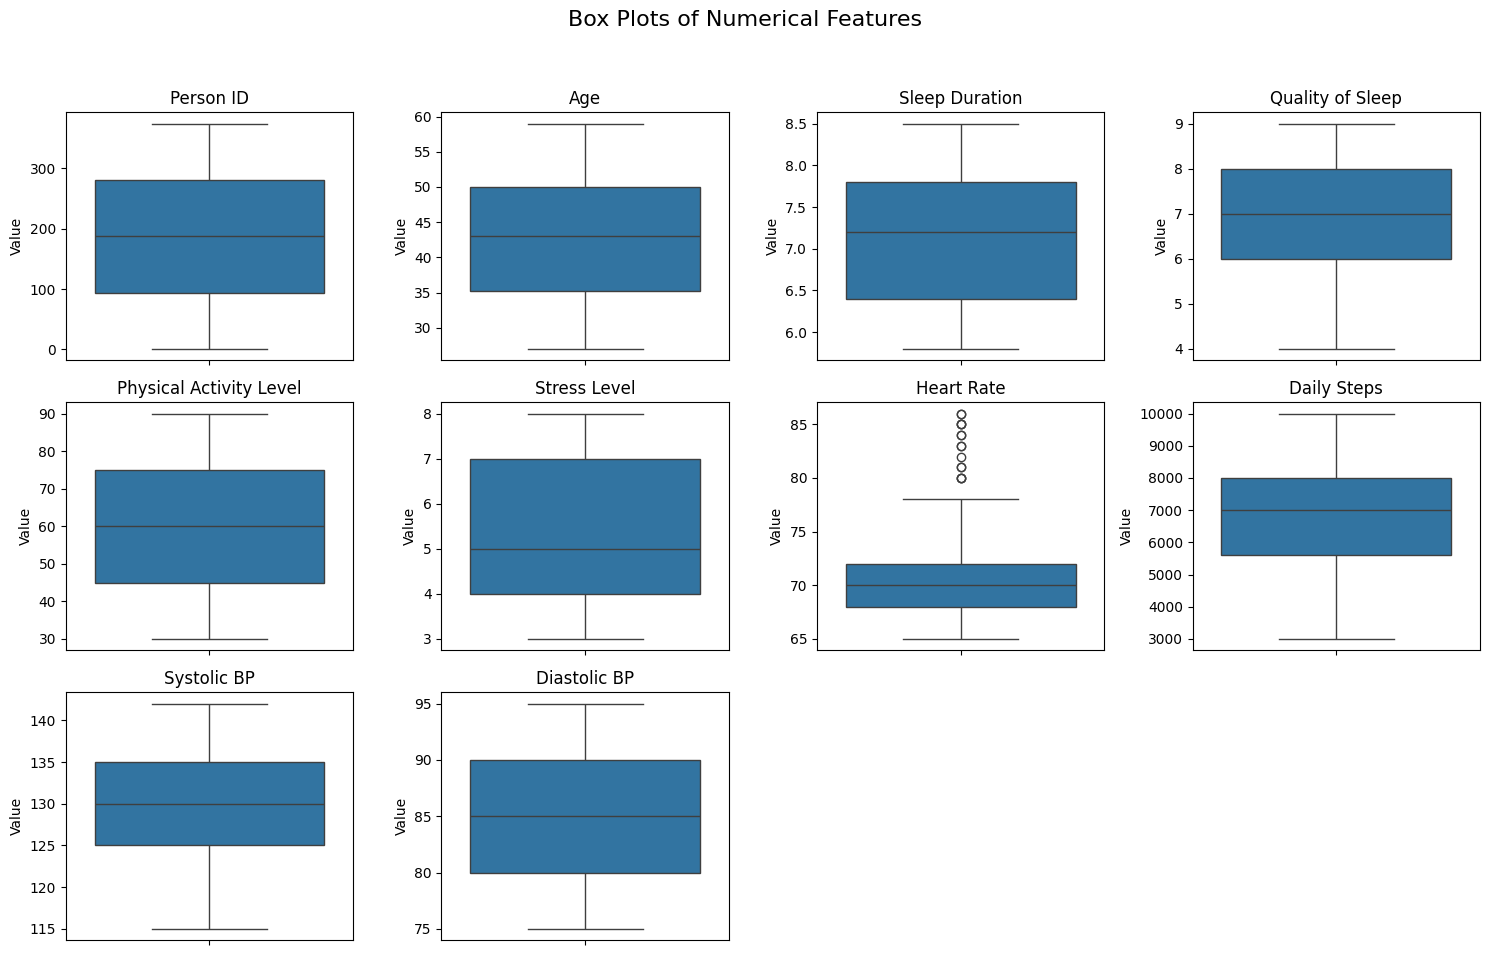

In [ ]:
import matplotlib.pyplot as plt
num_cols = len(numerical_columns)
rows = 3  # Adjust as needed
cols = (num_cols + rows - 1) // rows 

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))  
fig.suptitle('Box Plots of Numerical Features', fontsize=16)

for i, col in enumerate(numerical_columns):
    row_index = i // cols
    col_index = i % cols
    if rows > 1 and cols > 1: 
        ax = axes[row_index, col_index]
    elif rows == 1 and cols > 1:
        ax = axes[col_index]
    elif rows > 1 and cols == 1:
        ax = axes[row_index]
    else:
        ax = axes
    sns.boxplot(y=df[col], ax=ax) 
    ax.set_title(col)
    ax.set_ylabel('Value')


for j in range(i + 1, rows * cols):
    row_index = j // cols
    col_index = j % cols
    if rows > 1 and cols > 1:
        fig.delaxes(axes[row_index, col_index])
    elif rows == 1 and cols > 1:
        fig.delaxes(axes[col_index])
    elif rows > 1 and cols == 1:
        fig.delaxes(axes[row_index])
    else:
        pass

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()


In [18]:
df['Heart Rate'].value_counts()

Heart Rate
68    94
70    76
72    69
65    67
75    36
78     5
85     3
80     3
84     2
83     2
73     2
67     2
74     2
77     2
81     2
76     2
69     2
86     2
82     1
Name: count, dtype: int64

# IQR method

In [27]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return df_cleaned, outliers

numerical_columns_to_check = ['Physical Activity Level', 'Sleep Duration', 'Stress Level']
for column in numerical_columns_to_check:
    df, outliers = remove_outliers_iqr(df, column)
    print(f"Outliers removed from {column}: {len(outliers)}")

Outliers removed from Physical Activity Level: 0
Outliers removed from Sleep Duration: 0
Outliers removed from Stress Level: 0


i removed, using the Interquartile Range (IQR) method to identify outliers .i  have applied this method to specific numerical columns that are relevant for outlier detection in sleep health data. The function I used  returns both the cleaned dataframe and the outliers, which is useful for further analysis 

# Data Validation & Quality Checks


In [ ]:

df_cleaned  = df.copy()

In [ ]:

assert df_cleaned .isnull().sum().sum() == 0, "There are still missing values."


assert df_cleaned .duplicated().sum() == 0, "There are still duplicate records."


for col in numerical_columns_to_check:
    Q1 = df_cleaned [col].quantile(0.25)
    Q3 = df_cleaned [col].quantile(0.75)
    IQR = Q3 - Q1
    assert ((df_cleaned [col] >= Q1 - 1.5 * IQR) & (df_cleaned [col] <= Q3 + 1.5 * IQR)).all(), f"There are still outliers in {col}."


I have kept some validation checks Checking for missing values across the entire dataframe , the duplicate check ensures all duplicates have been removed and the outlier check using IQR is consistent with your removal method and verifies that outliers have been addressed in the specified columns.


# Feature Preprocessing

In [28]:



from sklearn.preprocessing import LabelEncoder


for column in non_numerical_columns:
    label_encoder = LabelEncoder()
    df_cleaned [column] = label_encoder.fit_transform(df_cleaned [column])


i am using label encode to convert the categorical columns to numerical columns

In [30]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    int32  
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    int32  
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    int32  
 9   Heart Rate               374 non-null    int64  
 10  Daily Steps              374 non-null    int64  
 11  Sleep Disorder           374 non-null    int32  
 12  Systolic BP              374 non-null    int32  
 13  Diastolic BP             374 non-null    int32  
dtypes: float64(1), int32(6), i

# loading the data

In [31]:
table_name = r'sleep_data_cleaned'
schema = r'cleaned' # schema we created this week.

df_cleaned.to_sql(table_name, con=db_conn, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')

374

In [7]:
table_name = r'sleep_data_cleaned'
schema = r'cleaned' # schema we created this week. 

df_cleaned = pd.read_sql_table(table_name, db_conn, schema)

In [8]:
df_cleaned

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic BP,Diastolic BP
0,1,1,27,9,6.1,6,42,6,3,77,4200,1,126,83
1,2,1,28,1,6.2,6,60,8,0,75,10000,1,125,80
2,3,1,28,1,6.2,6,60,8,0,75,10000,1,125,80
3,4,1,28,6,5.9,4,30,8,2,85,3000,2,140,90
4,5,1,28,6,5.9,4,30,8,2,85,3000,2,140,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,370,0,59,5,8.1,9,75,3,3,68,7000,2,140,95
370,371,0,59,5,8.0,9,75,3,3,68,7000,2,140,95
371,372,0,59,5,8.1,9,75,3,3,68,7000,2,140,95
372,373,0,59,5,8.1,9,75,3,3,68,7000,2,140,95


# star schema

# Creating dim_person table 

In [9]:
dim_person = df_cleaned[['Person ID', 'Gender', 'Age', 'Occupation', 'BMI Category']].drop_duplicates()
dim_person = dim_person.rename(columns={'Person ID': 'person_id'})
dim_person.to_sql('dim_person', db_conn, if_exists='replace', index=False, schema='cleaned')

374

# Create dim_sleep_disorder table

In [10]:
dim_sleep_disorder = df_cleaned[['Sleep Disorder']].drop_duplicates()
dim_sleep_disorder['sleep_disorder_id'] = range(1, len(dim_sleep_disorder) + 1)  # Add a unique ID
dim_sleep_disorder = dim_sleep_disorder[['sleep_disorder_id', 'Sleep Disorder']]
dim_sleep_disorder.to_sql('dim_sleep_disorder', db_conn, if_exists='replace', index=False, schema='cleaned')

3

# creating fact_sleep_health the fact table

In [12]:

df_fact = df_cleaned.merge(dim_person, left_on='Person ID', right_on='person_id', how='left')
df_fact = df_fact.merge(dim_sleep_disorder, left_on='Sleep Disorder', right_on='Sleep Disorder', how='left')


fact_sleep_health = df_fact[[
    'person_id', 'sleep_disorder_id',
    'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level',
    'Heart Rate', 'Daily Steps', 'Systolic BP', 'Diastolic BP'
]]


fact_sleep_health = fact_sleep_health.rename(columns={
    'Sleep Duration': 'sleep_duration',
    'Quality of Sleep': 'quality_of_sleep',
    'Physical Activity Level': 'physical_activity_level',
    'Stress Level': 'stress_level',
    'Heart Rate': 'heart_rate',
    'Daily Steps': 'daily_steps',
    'Systolic BP': 'systolic_bp',
    'Diastolic BP': 'diastolic_bp'
})


fact_sleep_health['sleep_id'] = range(1, len(fact_sleep_health) + 1)


fact_sleep_health = fact_sleep_health[[
    'sleep_id', 'person_id', 'sleep_disorder_id',
    'sleep_duration', 'quality_of_sleep', 'physical_activity_level', 'stress_level',
    'heart_rate', 'daily_steps', 'systolic_bp', 'diastolic_bp'
]]


fact_sleep_health.to_sql('fact_sleep_health', db_conn, if_exists='replace', index=False, schema='cleaned')

374


A star schema is a type of database schema commonly used in data warehousing and analytics.

It is designed to make data retrieval and analysis efficient by organizing data into a central fact table and surrounding dimension tables.

The fact table contains the measurable, quantitative data  while the dimension tables contain descriptive attributes.

Structure:
The fact table is the core of the star schema. It stores the numerical data that we want to analyze.

The dimension tables provide context to the data in the fact table. For example:

dim_person: Contains information about individuals .

dim_sleep_disorder: Contains information about sleep disorders .

Each dimension table is connected to the fact table through a foreign key.

Key Features:
Simplicity: The star schema is easy to understand and implement, even for non-technical users.

Query Optimization: It is optimized for read-heavy operations like aggregations and joins, making it ideal for analytics.